In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, ConfusionMatrixDisplay, RocCurveDisplay

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from imblearn.over_sampling import ADASYN

plt.style.use('seaborn')
%matplotlib inline

In [2]:
train_df = pd.read_csv("train.csv")
test=pd.read_csv("test.csv")
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450000 entries, 0 to 449999
Data columns (total 20 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_time            450000 non-null  object 
 1   order_id              450000 non-null  int64  
 2   order_date            450000 non-null  object 
 3   allot_time            450000 non-null  object 
 4   accept_time           449843 non-null  object 
 5   pickup_time           447579 non-null  object 
 6   delivered_time        444782 non-null  object 
 7   rider_id              450000 non-null  int64  
 8   first_mile_distance   450000 non-null  float64
 9   last_mile_distance    450000 non-null  float64
 10  alloted_orders        433052 non-null  float64
 11  delivered_orders      432659 non-null  float64
 12  cancelled             450000 non-null  int64  
 13  undelivered_orders    432659 non-null  float64
 14  lifetime_order_count  449947 non-null  float64
 15  

In [3]:
df = train_df.drop(['cancelled_time', 'pickup_time', 'delivered_time'], axis=1)


In [4]:
df.drop(['order_id', 'rider_id'], axis=1, inplace=True)

In [5]:
test.drop(['order_id', 'rider_id'], axis=1, inplace=True)

In [6]:
df.fillna({'reassigned_order': 0.0, 'reassignment_method': 'NA', 'reassignment_reason': 'NA'}, inplace=True)

In [7]:
test.fillna({'reassigned_order': 0.0, 'reassignment_method': 'NA', 'reassignment_reason': 'NA'}, inplace=True)

In [8]:
df['delivered_perc'] = (df['delivered_orders'] / df['alloted_orders'])
df.drop(['delivered_orders', 'alloted_orders', 'undelivered_orders'], axis=1, inplace=True)

In [9]:
test['delivered_perc'] = (test['delivered_orders'] / test['alloted_orders'])
test.drop(['delivered_orders', 'alloted_orders', 'undelivered_orders'], axis=1, inplace=True)

In [10]:
df.drop(['order_date'], axis=1, inplace=True)
df['order_time'] = df['order_time'].astype('datetime64[ns]')
df['allot_time'] = df['allot_time'].astype('datetime64[ns]')
df['accept_time'] = df['accept_time'].astype('datetime64[ns]')

df['allot_accept_lag'] = df['accept_time'] - df['allot_time']
df['allot_accept_lag'] = df['allot_accept_lag'].dt.total_seconds()

df.drop(['allot_time', 'accept_time'], axis=1, inplace=True)

In [11]:
test.drop(['order_date'], axis=1, inplace=True)
test['order_time'] = test['order_time'].astype('datetime64[ns]')
test['allot_time'] = test['allot_time'].astype('datetime64[ns]')
test['accept_time'] = test['accept_time'].astype('datetime64[ns]')

test['allot_accept_lag'] = test['accept_time'] - test['allot_time']
test['allot_accept_lag'] = test['allot_accept_lag'].dt.total_seconds()

test.drop(['allot_time', 'accept_time'], axis=1, inplace=True)

In [12]:
hour = df['order_time'].dt.hour  # 0, 1, 2, ..., 23
day = df['order_time'].dt.weekday  # 0, 1, ..., 6 (mon=0, sun=6)
is_weekend = [1 if i in [5, 6] else 0 for i in day]

df['order_hour'] = hour
df['order_day'] = day
df['order_is_weekend'] = is_weekend

df.drop(['order_time'], axis=1, inplace=True)

In [13]:
hour = test['order_time'].dt.hour  # 0, 1, 2, ..., 23
day = test['order_time'].dt.weekday  # 0, 1, ..., 6 (mon=0, sun=6)
is_weekend = [1 if i in [5, 6] else 0 for i in day]

test['order_hour'] = hour
test['order_day'] = day
test['order_is_weekend'] = is_weekend

test.drop(['order_time'], axis=1, inplace=True)

In [14]:
dummies  = pd.get_dummies(df['reassignment_method'], prefix='method')
df = pd.concat((df, dummies), axis=1)
df.drop(['reassignment_method'], axis=1, inplace=True)

dummies  = pd.get_dummies(df['reassignment_reason'], prefix='reason')
df = pd.concat((df, dummies), axis=1)
df.drop(['reassignment_reason'], axis=1, inplace=True)

In [15]:
dummies  = pd.get_dummies(test['reassignment_method'], prefix='method')
test = pd.concat((test, dummies), axis=1)
test.drop(['reassignment_method'], axis=1, inplace=True)

dummies  = pd.get_dummies(test['reassignment_reason'], prefix='reason')
test = pd.concat((test, dummies), axis=1)
test.drop(['reassignment_reason'], axis=1, inplace=True)

In [16]:
def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

df = encode(df, 'order_hour', 23)
df = encode(df, 'order_day', 6)

In [17]:
test

,order_id,rider_id,first_mile_distance,last_mile_distance,lifetime_order_count,reassigned_order,session_time,delivered_perc,allot_accept_lag,order_hour,order_day,order_is_weekend,method_NA,method_auto,method_manual,reason_Auto Reassignment basis Inaction. coreengine.tasks.repush_order_to_aa_bucket,reason_NA,reason_Reassign,reason_Reassignment Request from SE portal.
0,130231,12884,1.658500,4.54,747.0,0.0,273.400000,0.995370,26.0,10,5,1,1,0,0,0,1,0,0
1,130232,3541,2.070900,5.84,75.0,0.0,252.100000,1.000000,9.0,10,5,1,1,0,0,0,1,0,0
2,130233,603,1.388400,0.99,2214.0,0.0,241.383333,1.000000,80.0,10,5,1,1,0,0,0,1,0,0
3,130234,3414,1.903900,2.59,1020.0,0.0,291.933333,0.976000,23.0,10,5,1,1,0,0,0,1,0,0
4,130235,1426,0.827500,0.94,7284.0,0.0,247.133333,0.994318,60.0,10,5,1,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144839,41184,7141,1.417000,3.96,413.0,0.0,179.266667,1.000000,9.0,20,1,0,1,0,0,0,1,0,0
144840,41185,8113,0.775600,1.61,284.0,0.0,244.400000,0.978947,34.0,20,1,0,1,0,0,0,1,0,0
144841,41186,5040,2.049400,1.26,119.0,0.0,259.000000,1.000000,67.0,20,1,0,1,0,0,0,1,0,0
144842,41187,2946,0.080494,5.50,1759.0,0.0,814.283333,0.987013,24.0,20,1,0,1,0,0,0,1,0,0


In [18]:
def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

test = encode(test, 'order_hour', 23)
test = encode(test, 'order_day', 6)

In [19]:
df.drop(['order_hour', 'order_day'], axis=1, inplace=True)

In [20]:
test.drop(['order_hour', 'order_day'], axis=1, inplace=True)

In [21]:
y = df['cancelled'].values
X = df.drop(['cancelled'], axis=1)

In [22]:
X_test = test

In [23]:
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, stratify=y)

train_x.shape, test_x.shape, train_y.shape, test_y.shape

((360000, 21), (90000, 21), (360000,), (90000,))

In [24]:
# TODO: Use KNNImputer
imputer = SimpleImputer(strategy='mean')
train_x = imputer.fit_transform(train_x)
test_x = imputer.transform(test_x)

In [25]:
X_test = imputer.fit_transform(X_test)

In [26]:
np.bincount(train_y), np.bincount(test_y)

(array([355826,   4174]), array([88956,  1044]))

In [27]:
oversampler = ADASYN()
train_x, train_y = oversampler.fit_resample(train_x, train_y)

In [28]:
np.bincount(train_y), np.bincount(test_y)

(array([355826, 356304]), array([88956,  1044]))

In [29]:
scaler = StandardScaler()
train_x = scaler.fit_transform(train_x)
test_x = scaler.transform(test_x)

train_x.mean(), train_x.std(), test_x.mean(), test_x.std()

(5.545460814862604e-13,
 1.0000000000003417,
 -0.018843929949489517,
 0.8845818778021463)

# Model Building

In [108]:
model = xgb.XGBClassifier(n_estimators=100)
model.fit(train_x, train_y)

train_preds = model.predict(train_x)
test_preds = model.predict(test_x)

test_accuracy = accuracy_score(test_y, test_preds)
test_f1 = f1_score(test_y, test_preds)
train_accuracy = accuracy_score(train_y, train_preds)
train_f1 = f1_score(train_y, train_preds)

print(train_accuracy, train_f1)
print(test_accuracy, test_f1)

/Users/abhaylal/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:12:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.991192090696637 0.9911322702602698
0.9881444444444445 0.07136640557006092


In [96]:
ConfusionMatrixDisplay.from_predictions(test_y, test_preds, cmap='coolwarm')
plt.grid(False)

AttributeError: type object 'ConfusionMatrixDisplay' has no attribute 'from_predictions'

In [ ]:
ConfusionMatrixDisplay.from_predictions(train_y, train_preds, cmap='coolwarm')
plt.grid(False)

AttributeError: type object 'ConfusionMatrixDisplay' has no attribute 'from_predictions'

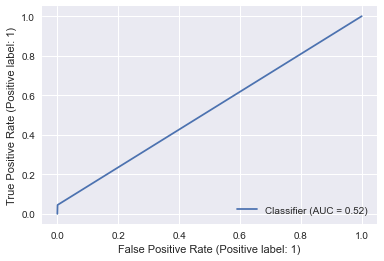

In [ ]:
RocCurveDisplay.from_predictions(test_y, test_preds)
plt.show()

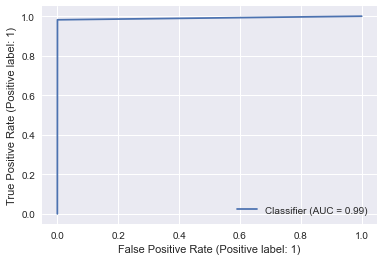

In [ ]:
RocCurveDisplay.from_predictions(train_y, train_preds)
plt.show()

array([[ 1.30231000e+05,  1.28840000e+04,  1.65850000e+00, ...,
        -9.17211302e-01, -8.66025404e-01,  5.00000000e-01],
       [ 1.30232000e+05,  3.54100000e+03,  2.07090000e+00, ...,
        -9.17211302e-01, -8.66025404e-01,  5.00000000e-01],
       [ 1.30233000e+05,  6.03000000e+02,  1.38840000e+00, ...,
        -9.17211302e-01, -8.66025404e-01,  5.00000000e-01],
       ...,
       [ 4.11860000e+04,  5.04000000e+03,  2.04940000e+00, ...,
         6.82553143e-01,  8.66025404e-01,  5.00000000e-01],
       [ 4.11870000e+04,  2.94600000e+03,  8.04939927e-02, ...,
         6.82553143e-01,  8.66025404e-01,  5.00000000e-01],
       [ 4.11880000e+04,  8.48800000e+03,  1.70210000e+00, ...,
         6.82553143e-01,  8.66025404e-01,  5.00000000e-01]])

In [109]:
model.predict(X_test)

array([1, 1, 1, ..., 1, 1, 1])

In [133]:
from collections import Counter
counter = Counter(y)
# estimate scale_pos_weight value
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)

Estimate: 85.240


In [31]:
final=pd.DataFrame()

In [32]:
new_test=pd.read_csv('test.csv')

In [33]:
final['order_id']=new_test['order_id']

In [34]:
final['cancelled']=model.predict(X_test)

In [35]:
final

,order_id,cancelled
0,130231,0
1,130232,0
2,130233,0
3,130234,0
4,130235,0
...,...,...
144839,41184,0
144840,41185,0
144841,41186,0
144842,41187,0


In [36]:
final.to_csv('submit_1.csv', index=False)

In [37]:
final['cancelled'].value_counts()

0    140172
1      4672
Name: cancelled, dtype: int64

In [163]:
final.shape

(144844, 2)

In [30]:
model = xgb.XGBClassifier(n_estimators=100,scale_pos_weight=85.24,min_child_weight=4,reg_alpha=0.05,learning_rate=0.1)
model.fit(X,y)

/Users/abhaylal/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:35:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=6, min_child_weight=4, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0.05, reg_lambda=1, scale_pos_weight=85.24, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)